# Introduction

trackintel documentation: https://trackintel.readthedocs.io/en/latest/modules/model.html#trackintel.Positionfixes

trackintel tutorial: https://github.com/mie-lab/trackintel/blob/master/examples/trackintel_basic_tutorial.ipynb

In [4]:
!pip install trackintel

In [5]:
import geopandas as gpd
import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import timedelta
from matplotlib import pyplot as plt
from multiprocessing import Pool
from shapely.geometry import LineString
from shapely.geometry import Point

import trackintel as ti

In [6]:
cityD = pd.read_csv('cityD_challengedata.csv.gz', compression='gzip')
cityD.head()

,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98
2,0,0,16,162,99
3,0,0,17,149,97
4,0,0,18,144,98


In [7]:
cityD.shape

(8418135, 5)

In [8]:
cityD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8418135 entries, 0 to 8418134
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 321.1 MB


`d`: Days since start of the data collection, ranges from 0-74 (the data is collected over 75 days)   
`t`: Ranges from 0-47 (the data is collected every 30 mins, there is 48 such periods in 1 day)

# Data Preprocessing

Limit the data to only the first month's data (30 days), i.e. `d` < 30.

In [12]:
cityD = cityD[cityD['d'] < 30]

In [13]:
cityD.shape

(3389319, 5)

In [14]:
# Save to a temporary file for later use
cityD.to_csv('cityD_filtered.csv', index=False)

Here, we define an arbitrary start date of the data collected.

In [16]:
# Define the start date
start_date = pd.to_datetime("2024-01-01")

In [17]:
def preprocess_data(data, start_date):
    # Create Point geometries
    geometry = [Point(xy) for xy in zip(data['x'], data['y'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)
    gdf.set_crs(epsg=3857, inplace=True)

    # Convert 'd' (days since start) to actual date
    gdf['date'] = start_date + pd.to_timedelta(gdf['d'], unit='D')
    
    # Convert 't' (30-minute intervals) to time of day
    gdf['time'] = pd.to_timedelta(gdf['t'] * 30, unit='m')  # Each 't' is multiplied by 30 minutes
    
    # Combine 'date' and 'time' into a single datetime column
    gdf['datetime'] = gdf['date'] + gdf['time']

    return gdf

In [18]:
def remove_consecutive_duplicates(sequence):
    """Remove consecutive duplicate coordinates from a sequence."""
    cleaned_sequence = [sequence[0]]  # Start with the first element
    for i in range(1, len(sequence)):
        if sequence[i] != sequence[i - 1]:  # Only add if different from the previous point
            cleaned_sequence.append(sequence[i])
    return cleaned_sequence

def preprocess_tripleg(dataset):
    """Preprocess each tripleg in the dataset by removing consecutive duplicates."""
    return [remove_consecutive_duplicates(sequence) for sequence in dataset]

In [19]:
def split_triplegs(triplegs, max_length):
    processed_triplegs = []
    for tripleg in triplegs:      
        # Split if the cleaned tripleg is too long
        if len(tripleg) > max_length:
            for i in range(0, len(tripleg), max_length):
                processed_triplegs.append(tripleg[i:i + max_length])
        else:
            processed_triplegs.append(tripleg)
    return processed_triplegs

In [20]:
def generate_candidates(sequences, length, frequent_subsequences):
    """Generate candidate sequences of a specified length by merging sequences with common prefixes/suffixes.
    Includes Apriori check to remove candidate sequences with any non-frequent subsequence.
    """
    candidates = set()
    for s1 in sequences:
        for s2 in sequences:
            # Merge two sequences if they share length-1 items
            if s1[1:] == s2[:-1]:  # Ensure that only relevant sequences are merged
                candidate = s1 + (s2[-1],)
                # Apriori check: Keep only if all (length-1) subsequences are frequent
                if all(candidate[i:i+length-1] in frequent_subsequences for i in range(len(candidate) - length + 1)):
                    candidates.add(candidate)
                    
    return candidates

def is_subsequence(subseq, sequence):
    """Optimized subsequence checking with indexed positions."""
    # Create a dictionary to index positions of each item in 'sequence'
    index_map = defaultdict(list)
    for idx, item in enumerate(sequence):
        index_map[item].append(idx)
    
    # Track the last matched index in 'sequence' for each item in 'subseq'
    current_pos = -1
    for item in subseq:
        # Early termination if item not in sequence
        if item not in index_map:
            return False
        # Use binary search to find the smallest position greater than current_pos
        positions = index_map[item]
        found = False
        for pos in positions:
            if pos > current_pos:
                current_pos = pos
                found = True
                break
        if not found:
            return False
    return True

def count_support(dataset, candidates, min_support):
    """Support counting."""
    candidate_count = defaultdict(int)

    for sequence in dataset:
        # Filter out sequences that are too short to contain any candidates of the current length
        if len(sequence) < len(next(iter(candidates))):  # All candidates are of the same length
            continue

        for candidate in candidates:
            # Early stopping: stop counting if min_support is reached
            if candidate_count[candidate] >= min_support:
                continue
            
            # Check if the candidate is a subsequence and update cache
            if is_subsequence(candidate, sequence):
                candidate_count[candidate] += 1

    # Filter out candidates with support below min_support
    frequent_sequences = {seq: count for seq, count in candidate_count.items() if count >= min_support}
    return frequent_sequences

def gsp_algorithm(dataset, min_support, max_k=10):
    """Run the GSP algorithm on the dataset, storing frequent patterns as a dictionary with their support counts."""
    # Step 1: Start with single-item sequences as initial candidates
    unique_items = {item for sequence in dataset for item in sequence}
    current_sequences = {(item,) for item in unique_items}
    frequent_patterns = {}
    k = 1
    
    while current_sequences and k <= max_k:
        print(f"Step {k}: Generating candidates of length {k}")
        
        # Step 2: Count support and keep frequent sequences
        frequent_seqs = count_support(dataset, current_sequences, min_support)
        if not frequent_seqs:
            break
        
        # Add the current frequent sequences to the overall patterns dictionary
        frequent_patterns.update(frequent_seqs)
        
        # Step 3: Generate new candidates with Apriori pruning
        frequent_subsequences = set(frequent_seqs.keys())
        current_sequences = generate_candidates(frequent_subsequences, k+1, frequent_subsequences)
        k += 1
    
    return frequent_patterns

In [21]:
# Define constants
chunk_size = 100000  # Number of rows to load per chunk
min_support = 5  # Minimum support for frequent patterns
gap_threshold = 45  # Gap threshold for staypoint detection
dist_threshold = 10  # Distance threshold for staypoints
max_tripleg_length = 10

In [22]:
# Dictionary to store patterns by chunk
all_frequent_patterns = defaultdict(list)

In [23]:
# Process data in chunks
for chunk in pd.read_csv('cityD_filtered.csv', chunksize=chunk_size):
    # Preprocess each chunk
    gdf_chunk = preprocess_data(chunk, start_date)
    
    # Generate position fixes and triplegs
    pfs_chunk = ti.io.read_positionfixes_gpd(gdf_chunk, tracked_at="datetime", user_id="uid", geom_col="geometry", tz='Asia/Tokyo')
    pfs_chunk, sp_chunk = pfs_chunk.as_positionfixes.generate_staypoints(gap_threshold=gap_threshold, dist_threshold=dist_threshold, 
                                                                         print_progress=True)
    pfs_chunk, tpls_chunk = pfs_chunk.generate_triplegs(staypoints=sp_chunk, method='overlap_staypoints', gap_threshold=45)

    print(gdf_chunk[:5])
    
    # Convert triplegs to sequences
    tpls_chunk['tripleg_list'] = tpls_chunk['geom'].apply(lambda geom: list(geom.coords))
    tripleg_list = tpls_chunk['tripleg_list'].tolist()
    
    # Preprocess triplegs by removing consecutive duplicates
    processed_triplegs = preprocess_tripleg(tripleg_list)
    splitted_triplegs = split_triplegs(processed_triplegs, 10)
    
    # Apply GSP on each chunk and collect patterns
    frequent_patterns_chunk = gsp_algorithm(splitted_triplegs, min_support=min_support)
    all_frequent_patterns.update(frequent_patterns_chunk)

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:18<00:00,  8.86it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

   uid  d   t    x    y                 geometry       date            time  \
0    0  0  13  133  103  POINT (133.000 103.000) 2024-01-01 0 days 06:30:00   
1    0  0  14  143   98   POINT (143.000 98.000) 2024-01-01 0 days 07:00:00   
2    0  0  16  162   99   POINT (162.000 99.000) 2024-01-01 0 days 08:00:00   
3    0  0  17  149   97   POINT (149.000 97.000) 2024-01-01 0 days 08:30:00   
4    0  0  18  144   98   POINT (144.000 98.000) 2024-01-01 0 days 09:00:00   

             datetime  
0 2024-01-01 06:30:00  
1 2024-01-01 07:00:00  
2 2024-01-01 08:00:00  
3 2024-01-01 08:30:00  
4 2024-01-01 09:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:17<00:00, 10.04it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid  d   t    x   y                geometry       date  \
100000  168  1   8  145  49  POINT (145.000 49.000) 2024-01-02   
100001  168  1   9  145  49  POINT (145.000 49.000) 2024-01-02   
100002  168  1  10  145  49  POINT (145.000 49.000) 2024-01-02   
100003  168  1  11  145  49  POINT (145.000 49.000) 2024-01-02   
100004  168  1  13  152  54  POINT (152.000 54.000) 2024-01-02   

                  time            datetime  
100000 0 days 04:00:00 2024-01-02 04:00:00  
100001 0 days 04:30:00 2024-01-02 04:30:00  
100002 0 days 05:00:00 2024-01-02 05:00:00  
100003 0 days 05:30:00 2024-01-02 05:30:00  
100004 0 days 06:30:00 2024-01-02 06:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [00:18<00:00,  9.58it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid   d   t   x    y                geometry       date  \
200000  347  29  28  99   99   POINT (99.000 99.000) 2024-01-30   
200001  347  29  29  99   99   POINT (99.000 99.000) 2024-01-30   
200002  347  29  30  96  100  POINT (96.000 100.000) 2024-01-30   
200003  347  29  31  96  101  POINT (96.000 101.000) 2024-01-30   
200004  347  29  32  98  100  POINT (98.000 100.000) 2024-01-30   

                  time            datetime  
200000 0 days 14:00:00 2024-01-30 14:00:00  
200001 0 days 14:30:00 2024-01-30 14:30:00  
200002 0 days 15:00:00 2024-01-30 15:00:00  
200003 0 days 15:30:00 2024-01-30 15:30:00  
200004 0 days 16:00:00 2024-01-30 16:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [00:20<00:00,  7.82it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid  d   t    x  y               geometry       date            time  \
300000  523  0  23  186  5  POINT (186.000 5.000) 2024-01-01 0 days 11:30:00   
300001  523  0  24  184  4  POINT (184.000 4.000) 2024-01-01 0 days 12:00:00   
300002  523  0  25  186  5  POINT (186.000 5.000) 2024-01-01 0 days 12:30:00   
300003  523  0  26  186  5  POINT (186.000 5.000) 2024-01-01 0 days 13:00:00   
300004  523  0  27  186  5  POINT (186.000 5.000) 2024-01-01 0 days 13:30:00   

                  datetime  
300000 2024-01-01 11:30:00  
300001 2024-01-01 12:00:00  
300002 2024-01-01 12:30:00  
300003 2024-01-01 13:00:00  
300004 2024-01-01 13:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:20<00:00,  8.29it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid  d   t    x   y                geometry       date  \
400000  682  8  34  148  51  POINT (148.000 51.000) 2024-01-09   
400001  682  8  35  152  54  POINT (152.000 54.000) 2024-01-09   
400002  682  8  36  157  53  POINT (157.000 53.000) 2024-01-09   
400003  682  8  37  157  53  POINT (157.000 53.000) 2024-01-09   
400004  682  8  38  148  51  POINT (148.000 51.000) 2024-01-09   

                  time            datetime  
400000 0 days 17:00:00 2024-01-09 17:00:00  
400001 0 days 17:30:00 2024-01-09 17:30:00  
400002 0 days 18:00:00 2024-01-09 18:00:00  
400003 0 days 18:30:00 2024-01-09 18:30:00  
400004 0 days 19:00:00 2024-01-09 19:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:16<00:00, 10.30it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

        uid  d   t    x    y                 geometry       date  \
500000  849  8  41  101  101  POINT (101.000 101.000) 2024-01-09   
500001  849  8  43   91   98    POINT (91.000 98.000) 2024-01-09   
500002  849  8  44   74   69    POINT (74.000 69.000) 2024-01-09   
500003  849  9   2   74   69    POINT (74.000 69.000) 2024-01-10   
500004  849  9   3   74   69    POINT (74.000 69.000) 2024-01-10   

                  time            datetime  
500000 0 days 20:30:00 2024-01-09 20:30:00  
500001 0 days 21:30:00 2024-01-09 21:30:00  
500002 0 days 22:00:00 2024-01-09 22:00:00  
500003 0 days 01:00:00 2024-01-10 01:00:00  
500004 0 days 01:30:00 2024-01-10 01:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 171/171 [00:18<00:00,  9.40it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid  d  t   x  y              geometry       date            time  \
600000  1021  1  4  34  1  POINT (34.000 1.000) 2024-01-02 0 days 02:00:00   
600001  1021  1  5  34  1  POINT (34.000 1.000) 2024-01-02 0 days 02:30:00   
600002  1021  1  6  34  1  POINT (34.000 1.000) 2024-01-02 0 days 03:00:00   
600003  1021  1  7  31  1  POINT (31.000 1.000) 2024-01-02 0 days 03:30:00   
600004  1021  1  8  34  1  POINT (34.000 1.000) 2024-01-02 0 days 04:00:00   

                  datetime  
600000 2024-01-02 02:00:00  
600001 2024-01-02 02:30:00  
600002 2024-01-02 03:00:00  
600003 2024-01-02 03:30:00  
600004 2024-01-02 04:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:20<00:00,  8.97it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d   t   x   y               geometry       date  \
700000  1191  26  43  76  93  POINT (76.000 93.000) 2024-01-27   
700001  1191  26  45  77  93  POINT (77.000 93.000) 2024-01-27   
700002  1191  26  46  80  88  POINT (80.000 88.000) 2024-01-27   
700003  1191  26  47  80  88  POINT (80.000 88.000) 2024-01-27   
700004  1191  27   0  80  88  POINT (80.000 88.000) 2024-01-28   

                  time            datetime  
700000 0 days 21:30:00 2024-01-27 21:30:00  
700001 0 days 22:30:00 2024-01-27 22:30:00  
700002 0 days 23:00:00 2024-01-27 23:00:00  
700003 0 days 23:30:00 2024-01-27 23:30:00  
700004 0 days 00:00:00 2024-01-28 00:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [00:18<00:00,  9.82it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d   t    x   y                geometry       date  \
800000  1373  19  24  132  92  POINT (132.000 92.000) 2024-01-20   
800001  1373  19  25  131  93  POINT (131.000 93.000) 2024-01-20   
800002  1373  19  26  134  98  POINT (134.000 98.000) 2024-01-20   
800003  1373  19  27  140  99  POINT (140.000 99.000) 2024-01-20   
800004  1373  19  28  132  92  POINT (132.000 92.000) 2024-01-20   

                  time            datetime  
800000 0 days 12:00:00 2024-01-20 12:00:00  
800001 0 days 12:30:00 2024-01-20 12:30:00  
800002 0 days 13:00:00 2024-01-20 13:00:00  
800003 0 days 13:30:00 2024-01-20 13:30:00  
800004 0 days 14:00:00 2024-01-20 14:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:18<00:00,  9.41it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

         uid   d   t   x   y               geometry       date  \
900000  1550  28   0  36  83  POINT (36.000 83.000) 2024-01-29   
900001  1550  28   3  35  82  POINT (35.000 82.000) 2024-01-29   
900002  1550  28   4  35  82  POINT (35.000 82.000) 2024-01-29   
900003  1550  28  12  36  83  POINT (36.000 83.000) 2024-01-29   
900004  1550  28  16  37  84  POINT (37.000 84.000) 2024-01-29   

                  time            datetime  
900000 0 days 00:00:00 2024-01-29 00:00:00  
900001 0 days 01:30:00 2024-01-29 01:30:00  
900002 0 days 02:00:00 2024-01-29 02:00:00  
900003 0 days 06:00:00 2024-01-29 06:00:00  
900004 0 days 08:00:00 2024-01-29 08:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:17<00:00, 10.43it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x   y                geometry       date  \
1000000  1724  13  26  172  57  POINT (172.000 57.000) 2024-01-14   
1000001  1724  13  27  172  57  POINT (172.000 57.000) 2024-01-14   
1000002  1724  13  28  172  57  POINT (172.000 57.000) 2024-01-14   
1000003  1724  13  29  172  57  POINT (172.000 57.000) 2024-01-14   
1000004  1724  13  30  172  56  POINT (172.000 56.000) 2024-01-14   

                   time            datetime  
1000000 0 days 13:00:00 2024-01-14 13:00:00  
1000001 0 days 13:30:00 2024-01-14 13:30:00  
1000002 0 days 14:00:00 2024-01-14 14:00:00  
1000003 0 days 14:30:00 2024-01-14 14:30:00  
1000004 0 days 15:00:00 2024-01-14 15:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [00:20<00:00,  8.51it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x    y                 geometry       date  \
1100000  1905  18  44  107  102  POINT (107.000 102.000) 2024-01-19   
1100001  1905  18  45  102  100  POINT (102.000 100.000) 2024-01-19   
1100002  1905  18  46  107  102  POINT (107.000 102.000) 2024-01-19   
1100003  1905  18  47  107  102  POINT (107.000 102.000) 2024-01-19   
1100004  1905  19   0  107  102  POINT (107.000 102.000) 2024-01-20   

                   time            datetime  
1100000 0 days 22:00:00 2024-01-19 22:00:00  
1100001 0 days 22:30:00 2024-01-19 22:30:00  
1100002 0 days 23:00:00 2024-01-19 23:00:00  
1100003 0 days 23:30:00 2024-01-19 23:30:00  
1100004 0 days 00:00:00 2024-01-20 00:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:21<00:00,  7.96it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x   y                geometry       date  \
1200000  2080  24  44  189  18  POINT (189.000 18.000) 2024-01-25   
1200001  2080  24  45  189  18  POINT (189.000 18.000) 2024-01-25   
1200002  2080  24  46  189  18  POINT (189.000 18.000) 2024-01-25   
1200003  2080  24  47  189  18  POINT (189.000 18.000) 2024-01-25   
1200004  2080  25   0  189  18  POINT (189.000 18.000) 2024-01-26   

                   time            datetime  
1200000 0 days 22:00:00 2024-01-25 22:00:00  
1200001 0 days 22:30:00 2024-01-25 22:30:00  
1200002 0 days 23:00:00 2024-01-25 23:00:00  
1200003 0 days 23:30:00 2024-01-25 23:30:00  
1200004 0 days 00:00:00 2024-01-26 00:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [00:20<00:00,  8.66it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x   y                geometry       date  \
1300000  2250  11  29  109  29  POINT (109.000 29.000) 2024-01-12   
1300001  2250  11  30  109  29  POINT (109.000 29.000) 2024-01-12   
1300002  2250  11  31  109  29  POINT (109.000 29.000) 2024-01-12   
1300003  2250  11  32  109  29  POINT (109.000 29.000) 2024-01-12   
1300004  2250  11  36  109  29  POINT (109.000 29.000) 2024-01-12   

                   time            datetime  
1300000 0 days 14:30:00 2024-01-12 14:30:00  
1300001 0 days 15:00:00 2024-01-12 15:00:00  
1300002 0 days 15:30:00 2024-01-12 15:30:00  
1300003 0 days 16:00:00 2024-01-12 16:00:00  
1300004 0 days 18:00:00 2024-01-12 18:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [00:20<00:00,  8.73it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t    x   y                geometry       date  \
1400000  2428  4  20  171  42  POINT (171.000 42.000) 2024-01-05   
1400001  2428  4  21  182  56  POINT (182.000 56.000) 2024-01-05   
1400002  2428  4  22  181  65  POINT (181.000 65.000) 2024-01-05   
1400003  2428  4  23  183  69  POINT (183.000 69.000) 2024-01-05   
1400004  2428  4  24  183  68  POINT (183.000 68.000) 2024-01-05   

                   time            datetime  
1400000 0 days 10:00:00 2024-01-05 10:00:00  
1400001 0 days 10:30:00 2024-01-05 10:30:00  
1400002 0 days 11:00:00 2024-01-05 11:00:00  
1400003 0 days 11:30:00 2024-01-05 11:30:00  
1400004 0 days 12:00:00 2024-01-05 12:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:21<00:00,  8.06it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x    y                 geometry       date  \
1500000  2605  21  33  142  109  POINT (142.000 109.000) 2024-01-22   
1500001  2605  21  34  142  110  POINT (142.000 110.000) 2024-01-22   
1500002  2605  21  35  145  115  POINT (145.000 115.000) 2024-01-22   
1500003  2605  21  38  145  115  POINT (145.000 115.000) 2024-01-22   
1500004  2605  21  42  143  104  POINT (143.000 104.000) 2024-01-22   

                   time            datetime  
1500000 0 days 16:30:00 2024-01-22 16:30:00  
1500001 0 days 17:00:00 2024-01-22 17:00:00  
1500002 0 days 17:30:00 2024-01-22 17:30:00  
1500003 0 days 19:00:00 2024-01-22 19:00:00  
1500004 0 days 21:00:00 2024-01-22 21:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:20<00:00,  8.91it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
1600000  2780  23  33  98  102  POINT (98.000 102.000) 2024-01-24   
1600001  2780  23  38  98  108  POINT (98.000 108.000) 2024-01-24   
1600002  2780  23  39  97  115  POINT (97.000 115.000) 2024-01-24   
1600003  2780  23  42  99  106  POINT (99.000 106.000) 2024-01-24   
1600004  2780  23  43  97  109  POINT (97.000 109.000) 2024-01-24   

                   time            datetime  
1600000 0 days 16:30:00 2024-01-24 16:30:00  
1600001 0 days 19:00:00 2024-01-24 19:00:00  
1600002 0 days 19:30:00 2024-01-24 19:30:00  
1600003 0 days 21:00:00 2024-01-24 21:00:00  
1600004 0 days 21:30:00 2024-01-24 21:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 179/179 [00:21<00:00,  8.48it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x    y                 geometry       date  \
1700000  2961  10  26  112  103  POINT (112.000 103.000) 2024-01-11   
1700001  2961  10  35  112  103  POINT (112.000 103.000) 2024-01-11   
1700002  2961  10  36  113   98   POINT (113.000 98.000) 2024-01-11   
1700003  2961  10  37  116   74   POINT (116.000 74.000) 2024-01-11   
1700004  2961  10  38  122   58   POINT (122.000 58.000) 2024-01-11   

                   time            datetime  
1700000 0 days 13:00:00 2024-01-11 13:00:00  
1700001 0 days 17:30:00 2024-01-11 17:30:00  
1700002 0 days 18:00:00 2024-01-11 18:00:00  
1700003 0 days 18:30:00 2024-01-11 18:30:00  
1700004 0 days 19:00:00 2024-01-11 19:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:20<00:00,  8.62it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t    x   y                geometry       date  \
1800000  3139  4  44  148  51  POINT (148.000 51.000) 2024-01-05   
1800001  3139  4  45  148  51  POINT (148.000 51.000) 2024-01-05   
1800002  3139  4  47  148  51  POINT (148.000 51.000) 2024-01-05   
1800003  3139  5   0  148  51  POINT (148.000 51.000) 2024-01-06   
1800004  3139  5   1  148  51  POINT (148.000 51.000) 2024-01-06   

                   time            datetime  
1800000 0 days 22:00:00 2024-01-05 22:00:00  
1800001 0 days 22:30:00 2024-01-05 22:30:00  
1800002 0 days 23:30:00 2024-01-05 23:30:00  
1800003 0 days 00:00:00 2024-01-06 00:00:00  
1800004 0 days 00:30:00 2024-01-06 00:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:21<00:00,  8.31it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t    x   y                geometry       date  \
1900000  3313  3  34  185  53  POINT (185.000 53.000) 2024-01-04   
1900001  3313  3  35  184  60  POINT (184.000 60.000) 2024-01-04   
1900002  3313  3  36  179  61  POINT (179.000 61.000) 2024-01-04   
1900003  3313  4  13  183  61  POINT (183.000 61.000) 2024-01-05   
1900004  3313  4  14  186  47  POINT (186.000 47.000) 2024-01-05   

                   time            datetime  
1900000 0 days 17:00:00 2024-01-04 17:00:00  
1900001 0 days 17:30:00 2024-01-04 17:30:00  
1900002 0 days 18:00:00 2024-01-04 18:00:00  
1900003 0 days 06:30:00 2024-01-05 06:30:00  
1900004 0 days 07:00:00 2024-01-05 07:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 174/174 [00:20<00:00,  8.61it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x    y                 geometry       date  \
2000000  3487  11  25  104  113  POINT (104.000 113.000) 2024-01-12   
2000001  3487  11  27  103  112  POINT (103.000 112.000) 2024-01-12   
2000002  3487  11  28  103  113  POINT (103.000 113.000) 2024-01-12   
2000003  3487  11  30  102  111  POINT (102.000 111.000) 2024-01-12   
2000004  3487  11  31  103  113  POINT (103.000 113.000) 2024-01-12   

                   time            datetime  
2000000 0 days 12:30:00 2024-01-12 12:30:00  
2000001 0 days 13:30:00 2024-01-12 13:30:00  
2000002 0 days 14:00:00 2024-01-12 14:00:00  
2000003 0 days 15:00:00 2024-01-12 15:00:00  
2000004 0 days 15:30:00 2024-01-12 15:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3
Step 4: Generating candidates of length 4


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:21<00:00,  8.49it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x   y               geometry       date  \
2100000  3660   9  44  56  52  POINT (56.000 52.000) 2024-01-10   
2100001  3660   9  45  55  53  POINT (55.000 53.000) 2024-01-10   
2100002  3660   9  46  55  51  POINT (55.000 51.000) 2024-01-10   
2100003  3660  10   1  56  52  POINT (56.000 52.000) 2024-01-11   
2100004  3660  10   2  56  52  POINT (56.000 52.000) 2024-01-11   

                   time            datetime  
2100000 0 days 22:00:00 2024-01-10 22:00:00  
2100001 0 days 22:30:00 2024-01-10 22:30:00  
2100002 0 days 23:00:00 2024-01-10 23:00:00  
2100003 0 days 00:30:00 2024-01-11 00:30:00  
2100004 0 days 01:00:00 2024-01-11 01:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 181/181 [00:21<00:00,  8.27it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t    x   y                geometry       date  \
2200000  3841  6  38  188  69  POINT (188.000 69.000) 2024-01-07   
2200001  3841  6  39  189  68  POINT (189.000 68.000) 2024-01-07   
2200002  3841  6  40  188  69  POINT (188.000 69.000) 2024-01-07   
2200003  3841  6  42  188  69  POINT (188.000 69.000) 2024-01-07   
2200004  3841  6  43  188  71  POINT (188.000 71.000) 2024-01-07   

                   time            datetime  
2200000 0 days 19:00:00 2024-01-07 19:00:00  
2200001 0 days 19:30:00 2024-01-07 19:30:00  
2200002 0 days 20:00:00 2024-01-07 20:00:00  
2200003 0 days 21:00:00 2024-01-07 21:00:00  
2200004 0 days 21:30:00 2024-01-07 21:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.01it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x    y                 geometry       date  \
2300000  4021  26  42  106  117  POINT (106.000 117.000) 2024-01-27   
2300001  4021  26  43  106  117  POINT (106.000 117.000) 2024-01-27   
2300002  4021  26  44  107  118  POINT (107.000 118.000) 2024-01-27   
2300003  4021  26  46  107  120  POINT (107.000 120.000) 2024-01-27   
2300004  4021  26  47  111  131  POINT (111.000 131.000) 2024-01-27   

                   time            datetime  
2300000 0 days 21:00:00 2024-01-27 21:00:00  
2300001 0 days 21:30:00 2024-01-27 21:30:00  
2300002 0 days 22:00:00 2024-01-27 22:00:00  
2300003 0 days 23:00:00 2024-01-27 23:00:00  
2300004 0 days 23:30:00 2024-01-27 23:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.08it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x   y                geometry       date  \
2400000  4195  28  35  195  24  POINT (195.000 24.000) 2024-01-29   
2400001  4195  28  36  189  23  POINT (189.000 23.000) 2024-01-29   
2400002  4195  28  37  185  31  POINT (185.000 31.000) 2024-01-29   
2400003  4195  28  38  174  44  POINT (174.000 44.000) 2024-01-29   
2400004  4195  29  31  172  54  POINT (172.000 54.000) 2024-01-30   

                   time            datetime  
2400000 0 days 17:30:00 2024-01-29 17:30:00  
2400001 0 days 18:00:00 2024-01-29 18:00:00  
2400002 0 days 18:30:00 2024-01-29 18:30:00  
2400003 0 days 19:00:00 2024-01-29 19:00:00  
2400004 0 days 15:30:00 2024-01-30 15:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:19<00:00,  9.35it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x    y                 geometry       date  \
2500000  4375  21  11  108  142  POINT (108.000 142.000) 2024-01-22   
2500001  4375  21  12  110  149  POINT (110.000 149.000) 2024-01-22   
2500002  4375  21  13  111  149  POINT (111.000 149.000) 2024-01-22   
2500003  4375  21  14  110  149  POINT (110.000 149.000) 2024-01-22   
2500004  4375  21  15  110  149  POINT (110.000 149.000) 2024-01-22   

                   time            datetime  
2500000 0 days 05:30:00 2024-01-22 05:30:00  
2500001 0 days 06:00:00 2024-01-22 06:00:00  
2500002 0 days 06:30:00 2024-01-22 06:30:00  
2500003 0 days 07:00:00 2024-01-22 07:00:00  
2500004 0 days 07:30:00 2024-01-22 07:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 179/179 [00:18<00:00,  9.44it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t    x    y                 geometry       date  \
2600000  4556  2  32  103  117  POINT (103.000 117.000) 2024-01-03   
2600001  4556  2  33  103  117  POINT (103.000 117.000) 2024-01-03   
2600002  4556  2  34  103  117  POINT (103.000 117.000) 2024-01-03   
2600003  4556  2  35  102  117  POINT (102.000 117.000) 2024-01-03   
2600004  4556  2  36  102  117  POINT (102.000 117.000) 2024-01-03   

                   time            datetime  
2600000 0 days 16:00:00 2024-01-03 16:00:00  
2600001 0 days 16:30:00 2024-01-03 16:30:00  
2600002 0 days 17:00:00 2024-01-03 17:00:00  
2600003 0 days 17:30:00 2024-01-03 17:30:00  
2600004 0 days 18:00:00 2024-01-03 18:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3
Step 4: Generating candidates of length 4
Step 5: Generating candidates of length 5


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:20<00:00,  8.96it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x   y                geometry       date  \
2700000  4734  21  42  180  52  POINT (180.000 52.000) 2024-01-22   
2700001  4734  21  43  179  51  POINT (179.000 51.000) 2024-01-22   
2700002  4734  21  44  180  52  POINT (180.000 52.000) 2024-01-22   
2700003  4734  21  45  179  51  POINT (179.000 51.000) 2024-01-22   
2700004  4734  21  47  180  52  POINT (180.000 52.000) 2024-01-22   

                   time            datetime  
2700000 0 days 21:00:00 2024-01-22 21:00:00  
2700001 0 days 21:30:00 2024-01-22 21:30:00  
2700002 0 days 22:00:00 2024-01-22 22:00:00  
2700003 0 days 22:30:00 2024-01-22 22:30:00  
2700004 0 days 23:30:00 2024-01-22 23:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [00:19<00:00,  9.17it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t   x    y                geometry       date  \
2800000  4913  16  16  72  100  POINT (72.000 100.000) 2024-01-17   
2800001  4913  16  17  71  120  POINT (71.000 120.000) 2024-01-17   
2800002  4913  16  18  85  114  POINT (85.000 114.000) 2024-01-17   
2800003  4913  16  19  74  104  POINT (74.000 104.000) 2024-01-17   
2800004  4913  16  20  72  100  POINT (72.000 100.000) 2024-01-17   

                   time            datetime  
2800000 0 days 08:00:00 2024-01-17 08:00:00  
2800001 0 days 08:30:00 2024-01-17 08:30:00  
2800002 0 days 09:00:00 2024-01-17 09:00:00  
2800003 0 days 09:30:00 2024-01-17 09:30:00  
2800004 0 days 10:00:00 2024-01-17 10:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:20<00:00,  8.67it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x   y                geometry       date  \
2900000  5090  24  29  198  19  POINT (198.000 19.000) 2024-01-25   
2900001  5090  24  33  195  20  POINT (195.000 20.000) 2024-01-25   
2900002  5090  24  34  192  15  POINT (192.000 15.000) 2024-01-25   
2900003  5090  24  37  192  17  POINT (192.000 17.000) 2024-01-25   
2900004  5090  24  38  192  16  POINT (192.000 16.000) 2024-01-25   

                   time            datetime  
2900000 0 days 14:30:00 2024-01-25 14:30:00  
2900001 0 days 16:30:00 2024-01-25 16:30:00  
2900002 0 days 17:00:00 2024-01-25 17:00:00  
2900003 0 days 18:30:00 2024-01-25 18:30:00  
2900004 0 days 19:00:00 2024-01-25 19:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:19<00:00,  8.81it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x   y               geometry       date  \
3000000  5271  2  20  89  97  POINT (89.000 97.000) 2024-01-03   
3000001  5271  2  22  89  97  POINT (89.000 97.000) 2024-01-03   
3000002  5271  2  23  88  97  POINT (88.000 97.000) 2024-01-03   
3000003  5271  2  24  94  99  POINT (94.000 99.000) 2024-01-03   
3000004  5271  2  25  89  97  POINT (89.000 97.000) 2024-01-03   

                   time            datetime  
3000000 0 days 10:00:00 2024-01-03 10:00:00  
3000001 0 days 11:00:00 2024-01-03 11:00:00  
3000002 0 days 11:30:00 2024-01-03 11:30:00  
3000003 0 days 12:00:00 2024-01-03 12:00:00  
3000004 0 days 12:30:00 2024-01-03 12:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:19<00:00,  9.53it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid   d   t    x   y                geometry       date  \
3100000  5443  17  16  171  56  POINT (171.000 56.000) 2024-01-18   
3100001  5443  17  21  173  51  POINT (173.000 51.000) 2024-01-18   
3100002  5443  17  22  173  51  POINT (173.000 51.000) 2024-01-18   
3100003  5443  17  23  173  51  POINT (173.000 51.000) 2024-01-18   
3100004  5443  17  28  175  51  POINT (175.000 51.000) 2024-01-18   

                   time            datetime  
3100000 0 days 08:00:00 2024-01-18 08:00:00  
3100001 0 days 10:30:00 2024-01-18 10:30:00  
3100002 0 days 11:00:00 2024-01-18 11:00:00  
3100003 0 days 11:30:00 2024-01-18 11:30:00  
3100004 0 days 14:00:00 2024-01-18 14:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:18<00:00, 10.35it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x   y               geometry       date  \
3200000  5626  0   8  66  96  POINT (66.000 96.000) 2024-01-01   
3200001  5626  0   9  66  96  POINT (66.000 96.000) 2024-01-01   
3200002  5626  0  10  66  97  POINT (66.000 97.000) 2024-01-01   
3200003  5626  0  11  70  96  POINT (70.000 96.000) 2024-01-01   
3200004  5626  0  12  31  78  POINT (31.000 78.000) 2024-01-01   

                   time            datetime  
3200000 0 days 04:00:00 2024-01-01 04:00:00  
3200001 0 days 04:30:00 2024-01-01 04:30:00  
3200002 0 days 05:00:00 2024-01-01 05:00:00  
3200003 0 days 05:30:00 2024-01-01 05:30:00  
3200004 0 days 06:00:00 2024-01-01 06:00:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


100%|████████████████████████████████████████████████████████████████████████████████| 179/179 [00:17<00:00, 10.32it/s]
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
C:\Users\zhixu\anaconda3\Lib\site-packages\trackintel\preprocessing\positionfixes.py:440: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cond_overlap_end = cond_overlap & ~cond_temporal_gap.shift(-1).fillna(False) & pd.isna(pfs["tripleg_id"])
C:\Users\zhixu\a

          uid  d   t   x   y               geometry       date  \
3300000  5821  4  36  79  15  POINT (79.000 15.000) 2024-01-05   
3300001  5821  4  37  72  19  POINT (72.000 19.000) 2024-01-05   
3300002  5821  4  45  78  17  POINT (78.000 17.000) 2024-01-05   
3300003  5821  4  46  74  15  POINT (74.000 15.000) 2024-01-05   
3300004  5821  4  47  74  15  POINT (74.000 15.000) 2024-01-05   

                   time            datetime  
3300000 0 days 18:00:00 2024-01-05 18:00:00  
3300001 0 days 18:30:00 2024-01-05 18:30:00  
3300002 0 days 22:30:00 2024-01-05 22:30:00  
3300003 0 days 23:00:00 2024-01-05 23:00:00  
3300004 0 days 23:30:00 2024-01-05 23:30:00  
Step 1: Generating candidates of length 1
Step 2: Generating candidates of length 2
Step 3: Generating candidates of length 3


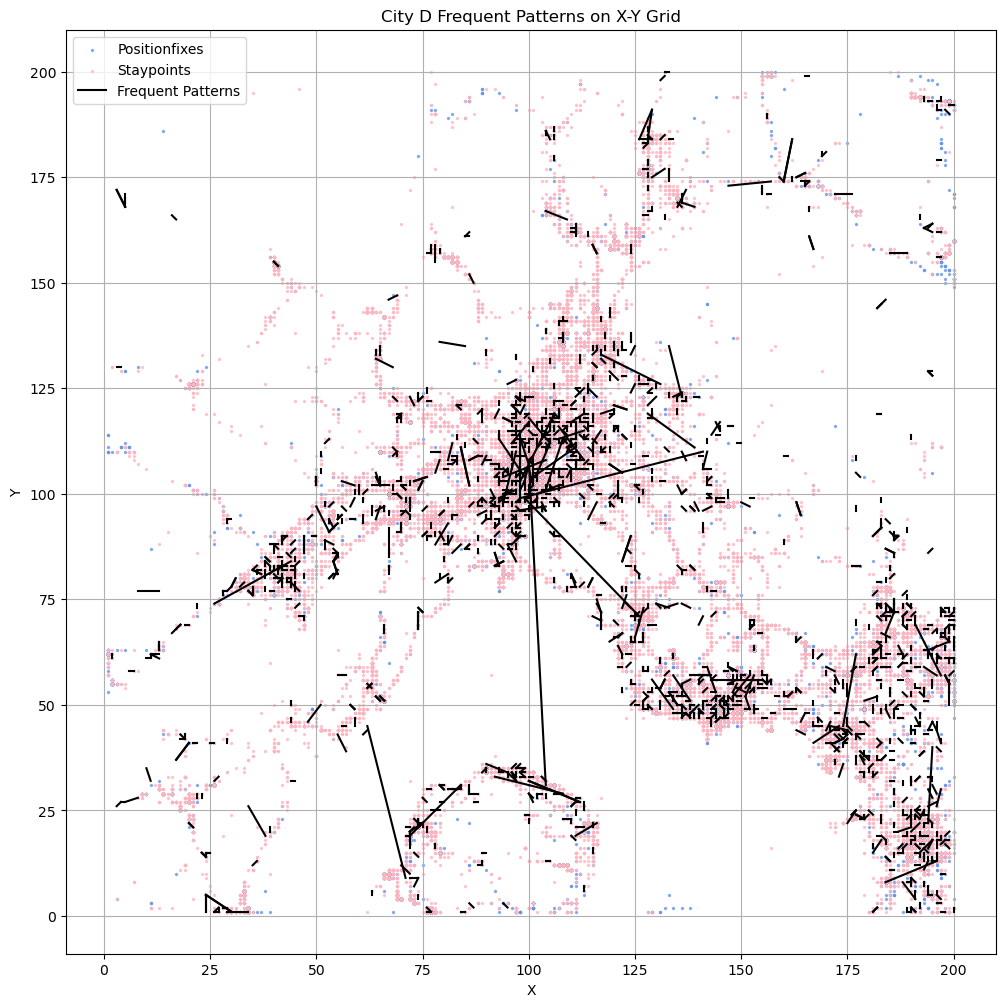

In [24]:
# Visualize top patterns
# Extract positionfixes and staypoints from a subset of processed data for visualization
positionfixes = pfs_chunk[pfs_chunk['staypoint_id'].isna()][:500000]
staypoints = pfs_chunk.dropna(subset=['staypoint_id'])[:500000]

plt.figure(figsize=(12, 12))
plt.scatter(positionfixes['x'], positionfixes['y'], label='Positionfixes', color='#6495ED', s=2, alpha=0.7)
plt.scatter(staypoints['x'], staypoints['y'], label='Staypoints', color='#FFB6C1', s=2, alpha=0.7)

# Plot each frequent pattern
for pattern, count in all_frequent_patterns.items():
    x_coords = [point[0] for point in pattern]
    y_coords = [point[1] for point in pattern]
    plt.plot(x_coords, y_coords, linestyle='-', alpha=1, linewidth=1.5, color='black')

# Add a legend entry for triplegs
plt.plot([], [], linestyle='-', color='black', label='Frequent Patterns')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('City D Frequent Patterns on X-Y Grid')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Convert the frequent patterns to a DataFrame for easier saving
patterns_df = pd.DataFrame({
    'Pattern': [pattern for pattern in all_frequent_patterns.keys()],
    'Count': [count for count in all_frequent_patterns.values()]
})

In [26]:
patterns_df.head()

,Pattern,Count
0,"((86.0, 27.0),)",5
1,"((144.0, 77.0),)",5
2,"((143.0, 57.0),)",5
3,"((96.0, 94.0),)",5
4,"((106.0, 105.0),)",5


In [27]:
patterns_df.shape

(6196, 2)

In [28]:
# Save the patterns to a CSV file
patterns_df.to_csv("cityD_frequent_patterns_minsup5.csv", index=False)

In [29]:
# Check for long patterns
long_patterns = patterns_df[patterns_df['Pattern'].apply(len) >= 3]

# Display the result
long_patterns

,Pattern,Count
2865,"((42.0, 89.0), (42.0, 90.0), (43.0, 90.0))",5
4388,"((76.0, 90.0), (77.0, 90.0), (76.0, 90.0))",5
4389,"((77.0, 90.0), (76.0, 90.0), (77.0, 90.0))",5
4984,"((50.0, 90.0), (49.0, 90.0), (50.0, 90.0))",5
5281,"((187.0, 90.0), (186.0, 90.0), (186.0, 90.0))",5
5282,"((186.0, 90.0), (187.0, 90.0), (187.0, 90.0))",5
5283,"((186.0, 89.0), (186.0, 90.0), (187.0, 90.0))",5
5284,"((187.0, 90.0), (187.0, 90.0), (186.0, 90.0))",5
5285,"((186.0, 90.0), (187.0, 90.0), (186.0, 90.0))",5
5286,"((187.0, 90.0), (186.0, 90.0), (187.0, 90.0))",5
